In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_8369/2313570758.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (c

# Divide data by displacement reason

In [4]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
pop_density = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/population_density.csv")
pop_count = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/pop_count.csv")
pop_density['admin1'] = pop_density['admin1'].str.replace('_',' ')
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')
inv_distance = 1/distance

df_d=pd.merge(df_d,pop_density,how='left',on=['year','admin1'],suffixes=('_norm', ''))
df_d=pd.merge(df_d,pop_count,how='left',on=['admin1'])
df_d = df_d.drop(['Awdal_x', 'Bakool_x', 'Banadir_x', 'Bari_x', 'Bay_x', 'Galgaduud_x',
       'Gedo_x', 'Hiraan_x', 'Lower_Juba_x', 'Lower_Shabelle_x',
       'Middle_Juba_x', 'Middle_Shabelle_x', 'Mudug_x', 'Nugaal_x', 'Sanaag_x',
       'Sool_x', 'Togdheer_x', 'Woqooyi_Galbeed_x', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'month_name','Awdal_y',
       'Bakool_y', 'Banadir_y', 'Bari_y', 'Bay_y', 'Galgaduud_y', 'Gedo_y',
       'Hiraan_y', 'Lower_Juba_y', 'Lower_Shabelle_y', 'Middle_Juba_y',
       'Middle_Shabelle_y', 'Mudug_y', 'Nugaal_y', 'Sanaag_y', 'Sool_y',
       'Togdheer_y', 'Woqooyi_Galbeed_y'], axis=1)

In [5]:
disp_data_d = disp_data[(disp_data['Reason']=='Drought related')]
disp_data_f = disp_data[(disp_data['Reason']=='Flood')]
disp_data_fd = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_c = disp_data[(disp_data['Reason']=='Conflict/Insecurity')]

agg_r=np.empty(4, dtype=object)
agg_d=np.empty(4, dtype=object)
disp_matxs_r=np.empty(4, dtype=object)
disp_matxs_d=np.empty(4, dtype=object)
agg_r_22, agg_d_22, disp_matxs_r_22, disp_matxs_d_22 = np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_17, agg_d_17, disp_matxs_r_17, disp_matxs_d_17 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_20, agg_d_20, disp_matxs_r_20, disp_matxs_d_20 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)
agg_r_21, agg_d_21, disp_matxs_r_21, disp_matxs_d_21 =np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object),np.empty(4, dtype=object)

for i,dd in enumerate([disp_data_d, disp_data_f, disp_data_fd, disp_data_c]):
    v= dd["Month End"]
    v=v.values
    dt = [datetime.strptime(v[j], "%d/%m/%Y") for j in range(len(v))]
    q=[]
    for j in range(len(dt)):
        q.append(datetime.timestamp(dt[j])) 
    dd.insert(loc=3, column='date_timestamp', value=q)
    dd=dd.sort_values("date_timestamp")
    dd['Month End'] = pd.to_datetime(dd['Month End'], dayfirst=True)

    #aggregate by region

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
    dates = aggregated_data.index.get_level_values('Month End').unique()
    regions = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
    all_combinations = pd.MultiIndex.from_product([dates, regions, regions], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
    agg_r[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_r[i] = agg_r[i].pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
    disp_matxs_r[i]['year'] = disp_matxs_r[i].index.get_level_values('time').year

    #subset the data
    agg_r_17[i] = agg_r[i][agg_r[i]['time'].dt.year==2017]
    disp_matxs_r_17[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2017]

    agg_r_20[i] = agg_r[i][agg_r[i]['time'].dt.year==2020]
    disp_matxs_r_20[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2020]

    agg_r_21[i] = agg_r[i][agg_r[i]['time'].dt.year==2021]
    disp_matxs_r_21[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2021]

    agg_r_22[i] = agg_r[i][agg_r[i]['time'].dt.year==2022]
    disp_matxs_r_22[i] = disp_matxs_r[i][disp_matxs_r[i]['year']==2022]

In [6]:
# to dictionary

agg_r = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r))
disp_matxs_r = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r))
disp_matxs_r_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_22))
agg_r_22 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_22))

disp_matxs_r_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_17))
agg_r_17 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_17))

disp_matxs_r_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_20))
agg_r_20 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_20))

disp_matxs_r_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_r_21))
agg_r_21 = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_r_21))


In [7]:
df_d_17 = df_d[df_d['year']==2017]
df_d_20 = df_d[df_d['year']==2020]
df_d_21 = df_d[df_d['year']==2021]
df_d_22 = df_d[df_d['year']==2022]

In [8]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']
lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_8369/2164771232.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


# Concatenate each destination 

In [96]:
# DROUGHT all y

vec_d=[]
for j in regions:
    
    disp_ji = disp_matxs_r['drought'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    inv_distance.index = inv_distance.columns.tolist()
    distance.index = distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd['distance'] = dd['Previous (Departure) Region'].map(distance[j])
    #dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) Region']!=j]
    
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) Region',
       'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep', 'pop_count_dep', 'pop_count_arr',
       'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr', 'distance', 'inv_distance'],
       value_vars=[j], var_name='Current (Arrival) Region', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc['inv_distance_2'] = df_conc['inv_distance']**2
df_conc.rename(columns={'year_dep':'year'}, inplace=True)
df_conc = df_conc[df_conc['Displacements']!=0]

In [82]:
# CONFLICT all y

vec_d=[]
for j in regions:
    
    disp_ji = disp_matxs_r['conflict'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) Region'], right_on=['time', 'admin1'])
    dd = dd.merge(df_d[df_d["admin1"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    inv_distance.index = inv_distance.columns.tolist()
    distance.index = distance.columns.tolist()
    dd['inv_distance'] = dd['Previous (Departure) Region'].map(inv_distance[j])
    dd['inv_distance'] = dd['inv_distance'].replace(np.inf, 1)
    dd['distance'] = dd['Previous (Departure) Region'].map(distance[j])
    #dd = dd[dd[j]!=0]
    dd = dd[dd['Previous (Departure) Region']!=j]
    
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) Region',
       'admin1_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'population_density_dep', 'pop_count_dep', 'pop_count_arr',
       'admin1_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr', 'population_density_arr', 'distance', 'inv_distance'],
       value_vars=[j], var_name='Current (Arrival) Region', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc['inv_distance_2'] = df_conc['inv_distance']**2
df_conc.rename(columns={'year_dep':'year'}, inplace=True)
df_conc = df_conc[df_conc['Displacements']!=0]

In [97]:
def assign_TA_lag(row):
    if 0 <= row['distance'] < 200:
        return row['TA_lag1_dep']
    elif 200 <= row['distance'] < 400:
        return row['TA_lag2_dep']
    elif 400 <= row['distance'] < 600:
        return row['TA_lag3_dep']
    elif 600 <= row['distance'] < 800:
        return row['TA_lag4_dep']
    else:
        return row['TA_lag5_dep']
    
def assign_PA_lag(row):
    if 0 <= row['distance'] < 200:
        return row['PA_lag1_dep']
    elif 200 <= row['distance'] < 400:
        return row['PA_lag2_dep']
    elif 400 <= row['distance'] < 600:
        return row['PA_lag3_dep']
    elif 600 <= row['distance'] < 800:
        return row['PA_lag4_dep']
    else:
        return row['PA_lag5_dep']

def assign_DL_lag(row):
    if 0 <= row['distance'] < 200:
        return row['DL_lag1_dep']
    elif 200 <= row['distance'] < 400:
        return row['DL_lag2_dep']
    elif 400 <= row['distance'] < 600:
        return row['DL_lag3_dep']
    elif 600 <= row['distance'] < 800:
        return row['DL_lag4_dep']
    else:
        return row['DL_lag5_dep']

def assign_conflicts_lag(row):
    if 0 <= row['distance'] < 200:
        return row['conflicts_lag1_dep']
    elif 200 <= row['distance'] < 400:
        return row['conflicts_lag2_dep']
    elif 400 <= row['distance'] < 600:
        return row['conflicts_lag3_dep']
    elif 600 <= row['distance'] < 800:
        return row['conflicts_lag4_dep']
    else:
        return row['conflicts_lag5_dep']



df_conc['TA_dep_lag_based_on_distance'] = df_conc.apply(assign_TA_lag, axis=1)
df_conc['PA_dep_lag_based_on_distance'] = df_conc.apply(assign_PA_lag, axis=1)
df_conc['DL_dep_lag_based_on_distance'] = df_conc.apply(assign_DL_lag, axis=1)
df_conc['conflicts_dep_lag_based_on_distance'] = df_conc.apply(assign_conflicts_lag, axis=1)

## GDP, pop_density and accessibility to cities

In [98]:
gdp_access = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/GDP.csv")
gdp_access['shapeName'].replace({'Hiiraan':'Hiraan','Lower Shebelle':'Lower Shabelle','Middle Shebelle':'Middle Shabelle'}, inplace=True)
gdp_access = gdp_access[['gdp_grid.none.mean','accessibility_to_cities_2015_v1.0.mean','shapeName']]
gdp_access.rename(columns={'gdp_grid.none.mean':'gdp_mean','accessibility_to_cities_2015_v1.0.mean':'accessibility_to_cities_mean'}, inplace=True)

df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Current (Arrival) Region'],right_on=['shapeName'])
df_conc = pd.merge(df_conc,gdp_access,how='left',left_on=['Previous (Departure) Region'],right_on=['shapeName'], suffixes=('_arr', '_dep'))
df_conc.drop(['shapeName_dep','shapeName_arr'], axis=1, inplace=True)

## Normalization

In [99]:
col2 =['conflicts_dep', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'population_density_dep','pop_count_dep', 'pop_count_arr',
       'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr',
       'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr',
       'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr',
       'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr',
       'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr',
       'DL_lag6_arr', 'conflicts_lag1_arr', 'conflicts_lag2_arr',
       'conflicts_lag3_arr', 'conflicts_lag4_arr', 'conflicts_lag5_arr',
       'conflicts_lag6_arr', 'sum_disp_arr', 'population_density_arr',
       'inv_distance', 'distance', 'Displacements', 
       'inv_distance_2', 'gdp_mean_arr', 'accessibility_to_cities_mean_arr',
       'gdp_mean_dep', 'accessibility_to_cities_mean_dep', 'TA_dep_lag_based_on_distance',
       'PA_dep_lag_based_on_distance', 'DL_dep_lag_based_on_distance', 'conflicts_dep_lag_based_on_distance']

In [100]:
df_conc_norm = df_conc.copy()

min_max_scaler = MinMaxScaler().fit(df_conc[col2])
df_conc_norm[col2] = min_max_scaler.transform(df_conc[col2])

In [101]:
#find columns with -inf
df_conc_norm['Displ_log'] = np.log(df_conc_norm['Displacements']+1)
df_conc_norm= df_conc_norm.replace(0, 0.001)

for col in col2:
    df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])

/tmp/ipykernel_8369/1067427376.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_8369/1067427376.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_8369/1067427376.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

<Axes: >

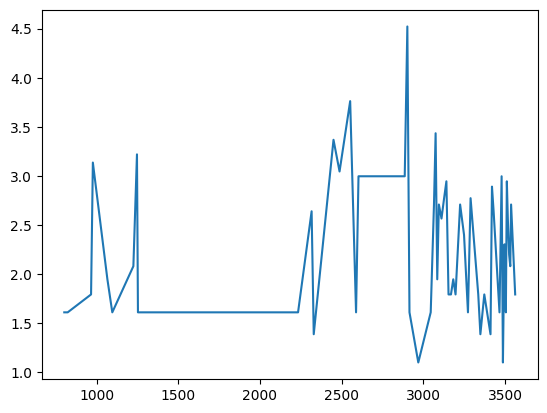

In [119]:
#create a random distribution and plot it
df_awdal= df_conc[df_conc['admin1_dep']=='Awdal']
#df_awdal['Displacements'].plot()
np.log(df_awdal['Displacements']).plot()

<Axes: >

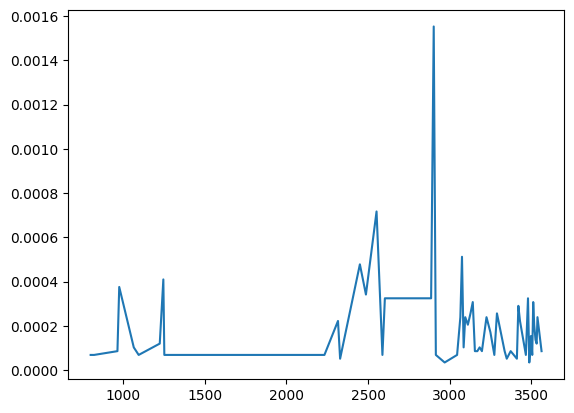

In [120]:
df_awdal= df_conc_norm[df_conc_norm['admin1_dep']=='Awdal']
df_awdal['Displacements'].plot()
#np.log(df_awdal['Displacements']).plot()

In [89]:
#df_conc_norm.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/gravity_zeros_c.csv", index=False)

In [90]:
df_awdal

NameError: name 'df_awdal' is not defined

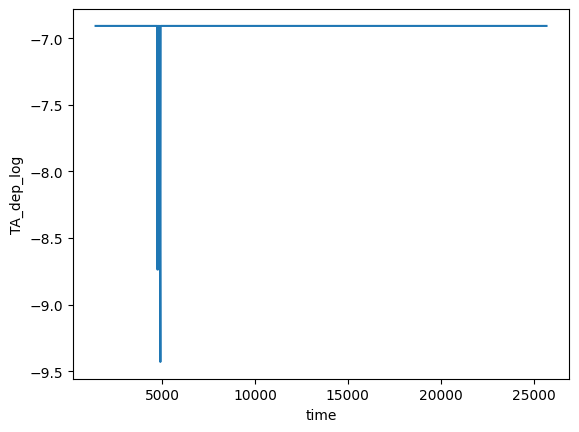

In [95]:
#plot df_conc['TA_dep_log'] in awdal
df_awdal= df_conc_norm[df_conc_norm['admin1_dep']=='Awdal']
fig, ax = plt.subplots()
ax.plot(df_awdal.index, df_awdal['Displacements_log'])
#ax.plot(df_awdal.index, df_awdal['Displacements'], color='r')
ax.set_xlabel('time')
ax.set_ylabel('TA_dep_log')
plt.show()

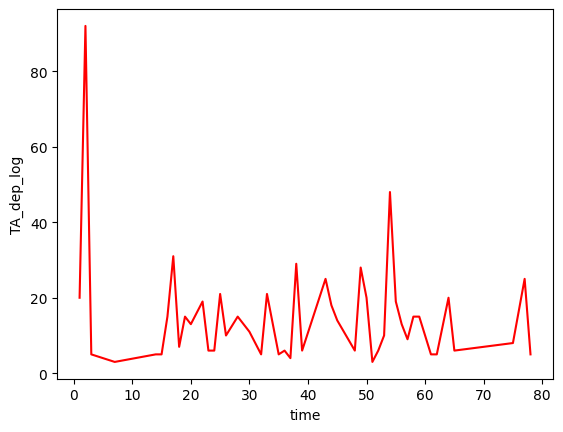

In [ ]:
#plot df_conc['TA_dep_log'] in awdal

df_awdal= df_conc[df_conc['admin1_dep']=='Awdal']
df_aw_s = df_awdal.groupby(['time']).agg({'Displacements':'sum'}).reset_index()
df_aw_s = df_aw_s[df_aw_s['Displacements']!=0]
fig, ax = plt.subplots()
#ax.plot(df_awdal.index, df_awdal['Disp_log'])
ax.plot(df_aw_s.index, df_aw_s['Displacements'], color='r')
ax.set_xlabel('time')
ax.set_ylabel('TA_dep_log')
plt.show()

In [ ]:
df_awdal

,time,Previous (Departure) Region,admin1_dep,tmx_dep,pre_dep,conflicts_dep,year,TA_dep,PA_dep,DL_dep,...,population_density_arr,distance,inv_distance,Current (Arrival) Region,Displacements,inv_distance_2,gdp_mean_arr,accessibility_to_cities_mean_arr,gdp_mean_dep,accessibility_to_cities_mean_dep
4845,2018-10,Awdal,Awdal,32.900000,11.375000,1.0,2018,0.406732,-0.007898,124,...,66.006908,742.268579,0.001347,Bari,5,0.000002,0.004420,446.431324,0.012453,262.064797
4879,2018-12,Awdal,Awdal,29.850002,5.275000,0.0,2018,0.164920,-0.094398,126,...,66.006908,742.268579,0.001347,Bari,5,0.000002,0.004420,446.431324,0.012453,262.064797
5100,2020-01,Awdal,Awdal,28.775000,6.500000,1.0,2020,0.192821,0.365762,139,...,69.676427,742.268579,0.001347,Bari,6,0.000002,0.004420,446.431324,0.012453,262.064797
5117,2020-02,Awdal,Awdal,29.800001,9.200000,0.0,2020,0.157575,0.408926,140,...,69.676427,742.268579,0.001347,Bari,23,0.000002,0.004420,446.431324,0.012453,262.064797
5270,2020-11,Awdal,Awdal,32.575000,10.975000,0.0,2020,1.249890,0.043601,5,...,69.676427,742.268579,0.001347,Bari,7,0.000002,0.004420,446.431324,0.012453,262.064797
5321,2021-02,Awdal,Awdal,30.025002,9.200000,0.0,2021,1.637765,-0.140419,8,...,71.511186,742.268579,0.001347,Bari,5,0.000002,0.004420,446.431324,0.012453,262.064797
5559,2022-04,Awdal,Awdal,33.675000,40.025000,0.0,2022,1.780334,-0.027002,9,...,73.345946,742.268579,0.001347,Bari,8,0.000002,0.004420,446.431324,0.012453,262.064797
5593,2022-06,Awdal,Awdal,37.250000,20.724998,0.0,2022,1.575112,0.543924,11,...,73.345946,742.268579,0.001347,Bari,25,0.000002,0.004420,446.431324,0.012453,262.064797
5610,2022-07,Awdal,Awdal,38.025000,18.700000,0.0,2022,1.340647,0.521062,12,...,73.345946,742.268579,0.001347,Bari,5,0.000002,0.004420,446.431324,0.012453,262.064797
17391,2017-04,Awdal,Awdal,32.625000,37.025000,2.0,2017,0.759003,-0.059783,106,...,76.108008,623.026648,0.001605,Mudug,5,0.000003,0.004996,409.944704,0.012453,262.064797


In [ ]:
#df_conc.to_csv('csv/df_new_all_c.csv')

In [ ]:
df_conc.columns

Index(['time', 'Previous (Departure) Region', 'admin1_dep', 'tmx_dep',
       'pre_dep', 'conflicts_dep', 'year', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'population_density_dep', 'admin1_arr', 'tmx_arr', 'pre_arr',
       'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr',
       'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr',
       'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr',
       'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr',
       'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr'

## Standardization

In [ ]:
df_conc_std = df_conc.copy()

scaler = StandardScaler().fit(df_conc[col2])
df_conc_std[col2] = scaler.transform(df_conc[col2])
df_conc.head()

,time,Previous (Departure) Region,admin1_dep,tmx_dep,pre_dep,conflicts_dep,year,TA_dep,PA_dep,DL_dep,...,distance,inv_distance,Current (Arrival) Region,Displacements,Disp_log,inv_distance_2,gdp_mean_arr,accessibility_to_cities_mean_arr,gdp_mean_dep,accessibility_to_cities_mean_dep
0,2016-01,Bakool,Bakool,34.450000,1.612500,6.0,2016,1.763821,0.482869,91,...,517.218397,0.001933,Awdal,7,1.945910,0.000004,0.012453,262.064797,0.004222,190.209430
1,2016-01,Banadir,Banadir,33.190000,6.130000,36.0,2016,0.945572,0.199790,12,...,711.218429,0.001406,Awdal,26,3.258097,0.000002,0.012453,262.064797,2.329651,16.304086
3,2016-01,Bay,Bay,34.357143,2.657143,16.0,2016,1.215753,0.388470,91,...,640.923618,0.001560,Awdal,13,2.564949,0.000002,0.012453,262.064797,0.007754,167.612994
4,2016-01,Galgaduud,Galgaduud,33.247055,4.352942,5.0,2016,1.403267,0.234548,12,...,572.573763,0.001746,Awdal,14,2.639057,0.000003,0.012453,262.064797,0.003434,266.761256
6,2016-01,Hiraan,Hiraan,34.027270,2.809091,10.0,2016,1.498989,0.256892,41,...,557.628353,0.001793,Awdal,14,2.639057,0.000003,0.012453,262.064797,0.004748,291.044337


In [ ]:
df_conc_norm['Displacements']

0        0.000102
1        0.000427
3        0.000205
4        0.000222
6        0.000222
           ...   
25683    0.000120
25684    0.000068
25686    0.000785
25702    0.000205
25703    0.001041
Name: Displacements, Length: 3630, dtype: float64

In [ ]:
np.log(df_conc_norm['Displacements'])

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       -9.186304
1       -7.759187
3       -8.493157
4       -8.413114
6       -8.413114
           ...   
25683   -9.032153
25684   -9.591769
25686   -7.149422
25702   -8.493157
25703   -6.867189
Name: Displacements, Length: 3630, dtype: float64

/home/sara/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


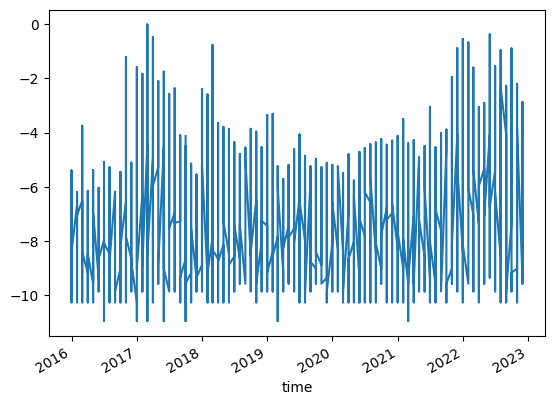

In [ ]:
#plot np.log(df_conc_norm['Displacements']) for Awdal region against time
df_conc_norm['time'] = pd.to_datetime(df_conc_norm['time'])
df_conc_norm = df_conc_norm.set_index('time')
df_conc_norm = df_conc_norm.sort_index()
df_conc_norm['log_disp'] = np.log(df_conc_norm['Displacements'])
df_conc_norm['log_disp'].plot()
plt.show()


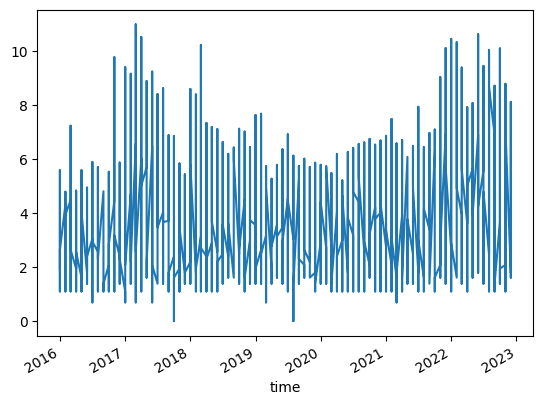

In [ ]:
#plot np.log(df_conc_norm['Displacements']) for Awdal region against time
df_conc['time'] = pd.to_datetime(df_conc['time'])
df_conc = df_conc.set_index('time')
df_conc = df_conc.sort_index()
df_conc['log_disp'] = np.log(df_conc['Displacements'])
df_conc['log_disp'].plot()
plt.show()

In [ ]:
df_conc_norm.head()

,time,Previous (Departure) Region,admin1_dep,tmx_dep,pre_dep,conflicts_dep,year,TA_dep,PA_dep,DL_dep,...,distance,inv_distance,Current (Arrival) Region,Displacements,Disp_log,inv_distance_2,gdp_mean_arr,accessibility_to_cities_mean_arr,gdp_mean_dep,accessibility_to_cities_mean_dep
0,2016-01,Bakool,Bakool,34.450000,1.612500,0.062500,2016,0.717408,0.514353,0.522989,...,0.376578,0.122535,Awdal,0.000102,0.177254,0.031743,0.004081,0.567118,0.000543,0.401304
1,2016-01,Banadir,Banadir,33.190000,6.130000,0.375000,2016,0.504880,0.423418,0.068966,...,0.552380,0.063982,Awdal,0.000427,0.296782,0.013411,0.004081,0.567118,1.000000,0.000000
3,2016-01,Bay,Bay,34.357143,2.657143,0.166667,2016,0.575055,0.484029,0.522989,...,0.488679,0.081103,Awdal,0.000205,0.233643,0.018173,0.004081,0.567118,0.002061,0.349161
4,2016-01,Galgaduud,Galgaduud,33.247055,4.352942,0.052083,2016,0.623759,0.434584,0.068966,...,0.426741,0.101782,Awdal,0.000222,0.240393,0.024583,0.004081,0.567118,0.000205,0.577956
6,2016-01,Hiraan,Hiraan,34.027270,2.809091,0.104167,2016,0.648621,0.441761,0.235632,...,0.413197,0.106979,Awdal,0.000222,0.240393,0.026308,0.004081,0.567118,0.000769,0.633991
